# Read Data

In [140]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd  '/content/gdrive/MyDrive/HCML/Explainability'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/HCML/Explainability


# Data Preparation

In [141]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit

diabetes_dataset = pd.read_csv('diabetes_130_raw.csv')
diabetes_dataset.drop(axis=1, columns=['weight', 'medical_specialty', 'payer_code'], inplace=True)
diabetes_dataset = diabetes_dataset.sort_values(by=['patient_nbr', 'encounter_id'])
# Define the ranges and replacement values
ICD9_mapping = [
    ((1, 139), 'Infectious And Parasitic Diseases'),
    ((140, 239), 'Neoplasms'),
    ((240, 279), 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders'),
    ((280, 289), 'Diseases Of The Blood And Blood-Forming Organs'),
    ((290, 319), 'Mental Disorders'),
    ((320, 389), 'Diseases Of The Nervous System And Sense Organs'),
    ((390, 459), 'Diseases Of The Circulatory System'),
    ((460, 519), 'Diseases Of The Respiratory System'),
    ((520, 579), 'Diseases Of The Digestive System'),
    ((580, 629), 'Diseases Of The Genitourinary System'),
    ((630, 679), 'Complications Of Pregnancy, Childbirth, And The Puerperium'),
    ((680, 709), 'Diseases Of The Skin And Subcutaneous Tissue'),
    ((710, 739), 'Diseases Of The Musculoskeletal System And Connective Tissue'),
    ((740, 759), 'Congenital Anomalies'),
    ((760, 779), 'Certain Conditions Originating In The Perinatal Period'),
    ((780, 799), 'Symptoms, Signs, And Ill-Defined Conditions'),
    ((800, 999), 'Injury And Poisoning'),
    ('V', 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'),
    ('E', 'Supplementary Classification Of External Causes Of Injury And Poisoning')
]

# Custom function to replace values based on multiple ranges
def replace_multiple_ranges(x, ranges_and_values):
    for values, new_value in ranges_and_values:
        if type(values) == tuple and x[0] != 'V' and x[0] != 'E' and x != '?':
            if values[0] <= int(float(x)) <= values[1]:
                return new_value
        elif type(values) == str and x[0] == values:
            return new_value
    return x

# Apply the custom function to the diagnosis columns
diabetes_dataset['diag_1'] = diabetes_dataset['diag_1'].apply(replace_multiple_ranges, args=(ICD9_mapping,))
diabetes_dataset['diag_2'] = diabetes_dataset['diag_2'].apply(replace_multiple_ranges, args=(ICD9_mapping,))
diabetes_dataset['diag_3'] = diabetes_dataset['diag_3'].apply(replace_multiple_ranges, args=(ICD9_mapping,))

# Replace '?' with 'no record' across diag_2 and diag_3
diabetes_dataset[['diag_2', 'diag_3']] = diabetes_dataset[['diag_2', 'diag_3']].replace('?', 'no record')

# Replace '?' with NaN
diabetes_dataset[['race', 'diag_1']] = diabetes_dataset[['race', 'diag_1']].replace('?', np.nan)

# Drop rows with missing values in columns 'race' and 'diag_1'
diabetes_dataset.dropna(subset=['race', 'diag_1'], inplace=True)

admission_type_id_mapping = {1:'Emergency',
                             2:'Urgent',
                             3:'Elective',
                             4:'Newborn',
                             5:'Not Available',
                             6:'NULL',
                             7:'Trauma Center',
                             8:'Not Mapped'
                            }

discharge_disposition_id_mapping = {1: 'ischarged to home',
                                    2:'ischarged/transferred to another short term hospital',
                                    3:'ischarged/transferred to SNF',
                                    4:'ischarged/transferred to ICF',
                                    5:'ischarged/transferred to another type of inpatient care institution',
                                    6:'ischarged/transferred to home with home health service',
                                    7:'eft AMA',
                                    8:'ischarged/transferred to home under care of Home IV provider',
                                    9:'dmitted as an inpatient to this hospital',
                                    10:'Neonate discharged to another hospital for neonatal aftercare',
                                    11:'Expired',
                                    12:'Still patient or expected to return for outpatient services',
                                    13:'Hospice / home',
                                    14:'Hospice / medical facility',
                                    15:'Discharged/transferred within this institution to Medicare approved swing bed',
                                    16:'Discharged/transferred/referred another institution for outpatient services',
                                    17:'Discharged/transferred/referred to this institution for outpatient services',
                                    18:'NULL',
                                    19:'Expired at home. Medicaid only, hospice.',
                                    20:'Expired in a medical facility. Medicaid only, hospice.',
                                    21:'Expired, place unknown. Medicaid only, hospice.',
                                    22:'Discharged/transferred to another rehab fac including rehab units of a hospital.',
                                    23:'Discharged/transferred to a long term care hospital.',
                                    24:'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
                                    25:'Not Mapped',
                                    26:'Unknown/Invalid',
                                    30:'Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere',
                                    27:'Discharged/transferred to a federal health care facility.',
                                    28:'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
                                    29:'Discharged/transferred to a Critical Access Hospital (CAH).'
                                    }

admission_source_id_mapping = {1: 'Physician Referral',
                               2: 'Clinic Referral',
                               3: 'HMO Referral',
                               4: 'Transfer from a hospital',
                               5: 'Transfer from a Skilled Nursing Facility (SNF)',
                               6: 'Transfer from another health care facility',
                               7: 'Emergency Room',
                               8: 'Court/Law Enforcement',
                               9: 'Not Available',
                               10:' Transfer from critial access hospital',
                               11:' Normal Delivery',
                               12:' Premature Delivery',
                               13:' Sick Baby',
                               14:' Extramural Birth',
                               15:' Not Available',
                               17:' NULL',
                               18:' Transfer From Another Home Health Agency',
                               19:' Readmission to Same Home Health Agency',
                               20:' Not Mapped',
                               21:' Unknown/Invalid',
                               22:' Transfer from hospital inpt/same fac reslt in a sep claim',
                               23:' Born inside this hospital',
                               24:' Born outside this hospital',
                               25:' Transfer from Ambulatory Surgery Center',
                               26:' Transfer from Hospice'
                               }

diabetes_dataset['admission_type_id'] = diabetes_dataset['admission_type_id'].replace(admission_type_id_mapping)
diabetes_dataset['discharge_disposition_id'] = diabetes_dataset['discharge_disposition_id'].replace(discharge_disposition_id_mapping)
diabetes_dataset['admission_source_id'] = diabetes_dataset['admission_source_id'].replace(admission_source_id_mapping)

## Old

In [156]:
'''
# select all categorical columns
categorical_columns = [col for col in diabetes_dataset.columns if not pd.api.types.is_numeric_dtype(diabetes_dataset[col])]

# Apply One-Hot Encoding for nominal categorical columns
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(diabetes_dataset[categorical_columns])

# Ensure correct shape when creating DataFrame for one-hot encoded data
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_columns), index=diabetes_dataset.index)

# Combine one-hot encoded columns with the rest of the DataFrame
df_encoded = pd.concat([diabetes_dataset.drop(columns=categorical_columns), one_hot_encoded_df], axis=1)

# Define the unique identifier column
unique_id_column = 'patient_nbr'

# Function to combine one-hot encoded target columns back to a single column
def combine_one_hot_encoded_target(df, target_prefix):
    # Find all columns that start with the target_prefix
    target_columns = [col for col in df.columns if col.startswith(target_prefix)]

    # Combine the columns into a single column
    def get_target_value(row):
        for col in target_columns:
            if row[col] == 1:
                return col.replace(target_prefix, '')
        return np.nan

    df[target_prefix[:-1]] = df.apply(get_target_value, axis=1)

    # Drop the one-hot encoded columns
    df.drop(columns=target_columns, inplace=True)

    return df

# Apply this function to your DataFrame
diabetes_dataset = combine_one_hot_encoded_target(diabetes_dataset, 'readmitted_')

# Ensure the target column is categorical
diabetes_dataset['readmitted'] = pd.Categorical(diabetes_dataset['readmitted'])
'''

# New

In [143]:
def sparse_encode(df):
    # select all categorical columns
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']

    # Convert string columns to categorical
    for col in categorical_columns:
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes.astype('category')

# Define the unique identifier column
def load_data(df):

    # encode dataframe first
    sparse_encode(df)

    # used for TAN
    variables_names = diabetes_dataset.columns.values
    target_variable = variables_names[-1]
    feature_variables = variables_names[:-1]

    unique_id_column = 'patient_nbr'

    # Split into training and remaining sets (validation + test)
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, remaining_idx = next(splitter.split(df, groups=df[unique_id_column]))

    train_df = df.iloc[train_idx]
    test_df = df.iloc[remaining_idx]

    # Split remaining set into validation and test sets
    #splitter = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    #val_idx, test_idx = next(splitter.split(remaining_df, groups=remaining_df[unique_id_column]))

    #val_df = remaining_df.iloc[val_idx]
    #test_df = remaining_df.iloc[test_idx]

    # remove patient number after use for splitting
    train_df, test_df = train_df.drop(['patient_nbr'], axis=1), test_df.drop(['patient_nbr'], axis=1)

    train_y = train_df['readmitted']
    train_df.drop(['readmitted'], axis=1, inplace=True)
    train_x = train_df

    test_y = test_df['readmitted']
    test_df.drop(['readmitted'], axis=1, inplace=True)
    test_x = test_df

    return target_variable, feature_variables, train_x, train_y, test_x, test_y

In [ ]:
target_variable, feature_variables, train_features, train_labels, test_features, test_labels = load_data(diabetes_dataset)

In [145]:
#diabetes_dataset = diabetes_dataset.dropna()

In [158]:
# used for TAN
variables_names = diabetes_dataset.columns.values
target_variable = variables_names[-1]
feature_variables = variables_names[:-1]

mask = np.random.rand(len(diabetes_dataset)) < 0.8
train = diabetes_dataset[mask]
test = diabetes_dataset[~mask]
test_no_target = test.copy().drop(target_variable, axis=1).reset_index()
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")

Training set shape: (79656, 47)
Test set shape: (19818, 47)


In [159]:
state_names = {name: column.unique() for name, column in diabetes_dataset.items()}
for key, value in state_names.items() :
    print(key, value)

#state_names['readmitted'] = ['<30', '>30', 'NO']

encounter_id [ 24437208  26264286  29758806 ... 338462954 443811536 371459060]
patient_nbr [      135       378       729 ... 189445127 189481478 189502619]
race [2, 0, 3, 1, 4]
Categories (5, int8): [0, 1, 2, 3, 4]
gender [0, 1, 2]
Categories (3, int8): [0, 1, 2]
age [5, 8, 3, 6, 4, 7, 1, 9, 2, 0]
Categories (10, int8): [0, 1, 2, 3, ..., 6, 7, 8, 9]
admission_type_id [7, 1, 0, 2, 5, 3, 4, 6]
Categories (8, int8): [0, 1, 2, 3, 4, 5, 6, 7]
discharge_disposition_id [19, 21, 25, 23, 20, ..., 10, 2, 17, 9, 14]
Length: 26
Categories (26, int8): [0, 1, 2, 3, ..., 22, 23, 24, 25]
admission_source_id [13, 10, 15, 16, 14, ..., 6, 2, 7, 4, 5]
Length: 17
Categories (17, int8): [0, 1, 2, 3, ..., 13, 14, 15, 16]
time_in_hospital [ 8  3  2  4  5  6 10 12  9  1 14 11  7 13]
num_lab_procedures [ 77  31  49  68  46  43  45  54  30  37  52  50  47  21  57  15  65  35
  27  44  36  51   2  58  59  38  64  33  39  66  62  75  56  48  67  40
  88  70  10  60  23  34  78  29  55  17  61  80  69  53  81  11 

# Training

In [ ]:
!pip install pgmpy

In [149]:
from collections import defaultdict

def predict(data, inf, target_variable):
    '''
    Given a Dataframe, an inference object and a target variable,
    perform prediction and return the obtained results
    '''
    results = defaultdict(list)
    for _, data_point in data.iterrows():
        if 'index' in data_point:
            del data_point['index']
        result = inf.query(
            variables=[target_variable],
            evidence=data_point.to_dict(),
            show_progress=False,
        )
        values = result.state_names[target_variable]
        for i, val in enumerate(values):
            results[val].append(result.values[i])
    return results

def perf_measure(test_data, predicted_data, positive_class, negative_class):
    '''
    Return the number of true positives, false positives, true negatives and
    false negatives
    '''
    tp, fp, tn, fn = 0, 0, 0, 0
    predicted_column = []
    keys = list(predicted_data.keys())
    for val in zip(*predicted_data.values()):
        max_index = np.argmax(val)
        predicted_column.append(keys[max_index])
    predicted_column = pd.Series(predicted_column, index=test_data.index)
    for actual, pred in zip(test_data, predicted_column):
        if actual == pred == positive_class:
           tp += 1
        if pred == positive_class and actual != pred:
           fp += 1
        if actual == pred == negative_class:
           tn += 1
        if pred == negative_class and actual != pred:
           fn += 1

    return (tp, fp, tn, fn)

def accuracy(test_data, predicted_data):
    '''
    Return a percentage representing the classification accuracy
    over the test set
    '''
    predicted_column = []
    keys = list(predicted_data.keys())
    for val in zip(*predicted_data.values()):
        max_index = np.argmax(val)
        predicted_column.append(keys[max_index])
    predicted_column = pd.Series(predicted_column, index=test_data.index)
    equality = predicted_column.eq(test_data)
    true_equality = equality[equality == True]
    return (len(true_equality) / len(test_data)) * 100

def precision(test_data, predicted_data, positive_class, negative_class):
    '''
    Return a percentage representing the classification precision
    over the test set
    '''
    tp, fp, _, _ = perf_measure(test_data, predicted_data, positive_class, negative_class)
    return (tp / (tp + fp)) * 100

def recall(test_data, predicted_data, positive_class, negative_class):
    '''
    Return a percentage representing the classification recall
    over the test set
    '''
    tp, _, _, fn = perf_measure(test_data, predicted_data, positive_class, negative_class)
    return (tp / (tp + fn)) * 100

def f_measure(test_data, predicted_data, positive_class, negative_class):
    '''
    Return a percentage representing the classification F-score
    over the test set
    '''
    p = precision(test_data, predicted_data, positive_class, negative_class)
    r = recall(test_data, predicted_data, positive_class, negative_class)
    return 2 * ((p * r) / (p + r))

### TAN

In [150]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import StructureEstimator
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG
from sklearn.metrics import mutual_info_score

class TreeAugmentedNaiveBayesSearch(StructureEstimator):

    def __init__(self, data, class_node, root_node=None, **kwargs):
        '''
        Search class for learning tree-augmented naive bayes (TAN) graph structure with a given set of variables.
        TAN is an extension of Naive Bayes classifer and allows a tree structure over the independent variables
        to account for interaction.
        See https://github.com/pgmpy/pgmpy/pull/1266/commits for reference.
        '''
        self.class_node = class_node
        self.root_node = root_node

        super().__init__(data, **kwargs)

    def estimate(self):
        '''
        Estimates the DAG structure that fits best to the given data set using the Chow-Liu algorithm.
        Only estimates network structure, no parametrization.
        '''
        if self.class_node not in self.data.columns:
            raise ValueError("Class node must exist in data")

        if self.root_node is not None and self.root_node not in self.data.columns:
            raise ValueError("Root node must exist in data")

        graph = nx.Graph()
        df_features = self.data.loc[:, self.data.columns != self.class_node]
        total_cols = len(df_features.columns)
        for i in range(total_cols):
            from_node = df_features.columns[i]
            graph.add_node(from_node)
            for j in range(i + 1, total_cols):
                to_node = df_features.columns[j]
                graph.add_node(to_node)
                mi = mutual_info_score(
                    df_features.iloc[:, i], df_features.iloc[:, j]
                )
                graph.add_edge(from_node, to_node, weight=mi)
        tree = nx.maximum_spanning_tree(graph)

        if self.root_node:
            digraph = nx.bfs_tree(tree, self.root_node)
        else:
            digraph = nx.bfs_tree(tree, df_features.columns[0])

        for node in df_features.columns:
            digraph.add_edge(self.class_node, node)

        return DAG(digraph)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


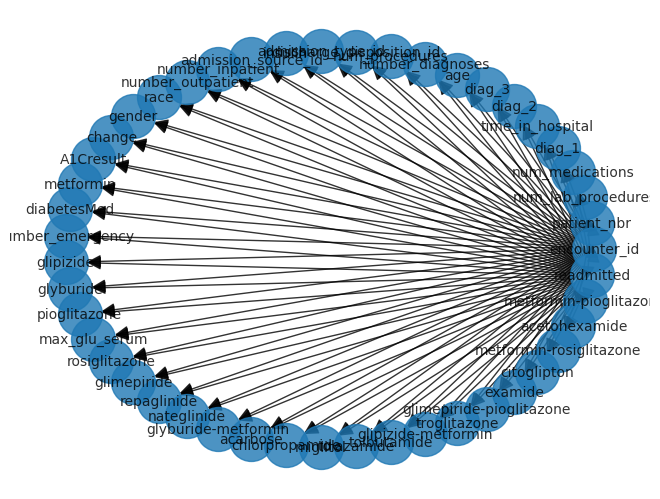

In [151]:
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import NaiveBayes, BayesianModel

%time
tan_estimator = TreeAugmentedNaiveBayesSearch(data=diabetes_dataset, class_node=target_variable)
tan_structure = tan_estimator.estimate()
tan_model = BayesianModel(tan_structure.edges)
nx.draw_circular(tan_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

The TAN model, without the target variable, is a tree.


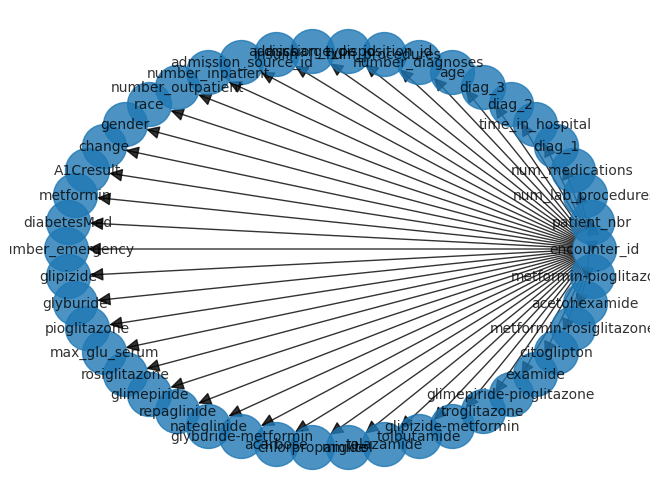

In [152]:
tree_check = tan_structure.copy()
tree_check.remove_node(target_variable)
if nx.is_tree(tree_check):
    print('The TAN model, without the target variable, is a tree.')
else:
    print('The TAN model, without the target variable, is not a tree.')
nx.draw_circular(tree_check, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)

In [160]:
from pgmpy.estimators import ExpectationMaximization, MaximumLikelihoodEstimator
#em_estimator = ExpectationMaximization(tan_model, train_features)
tan_model.fit(train, estimator=MaximumLikelihoodEstimator, state_names=state_names)

tan_cpds = tan_model.get_cpds()
if not tan_model.check_model():
    print('The TAN model has errors.')
else:
    print('The TAN model has no errors.')

ValueError: The state names must be for the form: {variable: list_of_states}

In [ ]:
%time
tan_inference = VariableElimination(tan_model)
tan_results = predict(test_no_target, tan_inference, target_variable)
tan_mean_results = {}
for k, v in tan_results.items():
    tan_mean_results[k] = np.nanmean(v)
print(tan_mean_results)

In [ ]:
tan_accuracy = accuracy(test[target_variable], tan_results)
print(f'The TAN model has {round(tan_accuracy, 3)} % accuracy over the test set.')
tan_precision = precision(test[target_variable], tan_results, positive_class='>50K', negative_class='<=50K')
print(f'The TAN model has {round(tan_precision, 3)} % precision over the test set.')
tan_recall = recall(test[target_variable], tan_results, positive_class='>50K', negative_class='<=50K')
print(f'The TAN model has {round(tan_recall, 3)} % recall over the test set.')
tan_f_score = f_measure(test[target_variable], tan_results, positive_class='>50K', negative_class='<=50K')
print(f'The TAN model has {round(tan_f_score, 3)} % F-score over the test set.')